# Napari image viewer

Uses the octopuslite dask image loader to automatically sort and load images from multichannel time lapse experiments. Can also use btrack to load associated tracks and segmentation images.

In [1]:
import napari
from octopuslite import DaskOctopusLiteLoader
import glob
import numpy as np

# Load images

In [2]:
# define experiment ID and select a position
expt = 'ND0013'
pos = 'Pos7'
# point to where the data is
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_paths = glob.glob(f'{root_dir}/{expt}/{pos}/*.npy')
print(transform_paths)
tracks_path = f'{root_dir}/{expt}/{pos}/tracks.h5'

['/home/nathan/data/kraken/ras/ND0013/Pos7/transform_tensor.npy']


In [3]:
transform_path = transform_paths[0] #'/home/nathan/data/kraken/ras/ND0019/Pos2/mask_reversed_clipped_transform_tensor.npy'

In [4]:
# lazily load images
images = DaskOctopusLiteLoader(image_path, 
                              transforms = transform_path,
                               crop = (1200,1600),
                               remove_background = True)
images.channels

Using cropping: (1200, 1600)


[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK: 99>]

In [7]:
gfp = images['gfp']
rfp = images['rfp']
# irfp = images['irfp']
masks = images['mask'].astype(np.uint8)

### Add tracks

In [8]:
import btrack
from btrack.utils import tracks_to_napari

#### GFP tracks

In [9]:
with btrack.dataio.HDF5FileHandler(tracks_path, 
                                   'r', obj_type='obj_type_1'
                                  ) as h:
    gfp_tracks = h.tracks

[INFO][2022/04/04 02:45:50 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0013/Pos7/tracks.h5...
[INFO][2022/04/04 02:45:50 PM] Loading tracks/obj_type_1
[INFO][2022/04/04 02:45:51 PM] Loading objects/obj_type_1 (1128253, 5) (1128253 filtered: None)
[INFO][2022/04/04 02:46:10 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0013/Pos7/tracks.h5


In [10]:
gfp_tracks, gfp_properties, gfp_graph = tracks_to_napari(gfp_tracks, ndim = 2)

#### RFP tracks

In [11]:
with btrack.dataio.HDF5FileHandler(tracks_path, 
                                   'r', obj_type='obj_type_2'
                                  ) as h:
    rfp_tracks = h.tracks

[INFO][2022/04/04 02:46:20 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0013/Pos7/tracks.h5...
[INFO][2022/04/04 02:46:20 PM] Loading tracks/obj_type_2
[INFO][2022/04/04 02:46:21 PM] Loading objects/obj_type_2 (863939, 5) (863939 filtered: None)
[INFO][2022/04/04 02:46:34 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0013/Pos7/tracks.h5


In [12]:
rfp_tracks, rfp_properties, rfp_graph = tracks_to_napari(rfp_tracks, ndim = 2)

# Launch viewer

In [13]:
len(gfp)

2797

In [14]:
N = 2797 ## number of frames to load

In [15]:
viewer = napari.Viewer()
viewer.add_image(gfp[0:N].astype(np.uint8), name="gfp", 
                 contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_image(rfp[0:N].astype(np.uint8), name="rfp", 
                 contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')#, is_pyramid=False)
# viewer.add_image(irfp[0:N].astype(np.uint8), name="irfp", 
#                  contrast_limits=[0,255], 
#                  blending = 'additive', colormap = 'cyan')#
viewer.add_labels(masks[0:N].astype(np.uint8), name = 'masks',
               blending = 'additive',)
viewer.add_tracks(gfp_tracks)
viewer.add_tracks(rfp_tracks)

Assistant skips harvesting pyclesperanto as it's not installed.


__init__.py (165): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Tracks layer 'rfp_tracks' at 0x7f2ff142b070>

In [8]:
import sys
sys.path.append('../../')
from generator import image_generator

In [9]:
from tqdm.auto import tqdm

In [7]:
%%timeit
gfp = images['gfp'].compute()

ValueError: '/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000003_z000.tif' is not in list

In [10]:
files = images.files('GFP')

In [ ]:
%%time
stack = []
for i in tqdm(image_generator(files), total = len(files)):
    stack.append(i)
stack = np.dstack(stack)

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

In [11]:
from skimage.io import imread

In [ ]:
%%timeit
stack = []
for i in tqdm((files), total = len(files)):
    img = imread(i)
    stack.append(img)
stack_1 = np.dstack(stack)

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

In [6]:
for i in files:
    print(i)

/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000000_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000001_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000002_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000003_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000004_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000005_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000006_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000007_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_position007_time000000008_z000.tif
/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel001_posit

In [15]:
viewer = napari.Viewer()

viewer.add_image(stack)

Assistant skips harvesting pyclesperanto as it's not installed.


__init__.py (165): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Image layer 'stack' at 0x7f22b81d78e0>

# Ras mask tidier

In [27]:
masks[0]

dask.array<getitem, shape=(1200, 1600), dtype=int64, chunksize=(1200, 1600), chunktype=numpy.ndarray>

In [29]:
masks[0]

dask.array<getitem, shape=(1200, 1600), dtype=uint8, chunksize=(1200, 1600), chunktype=numpy.ndarray>

In [3]:
from scipy.ndimage import label

In [4]:
from scipy.ndimage import gaussian_filter

In [5]:
from scipy.ndimage import binary_erosion

In [6]:
from skimage.io import imshow
%matplotlib inline

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


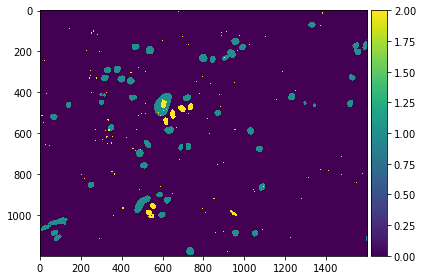

In [34]:
imshow(masks[0])

In [37]:
label(masks[0])[-1]

287

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


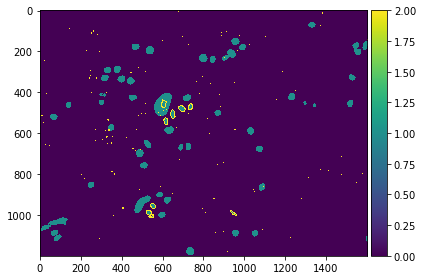

In [45]:
imshow(masks[0]-gaussian_filter(masks[0]==2, sigma = 1))

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


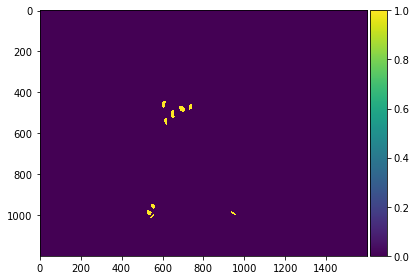

In [76]:
imshow((binary_erosion((masks[0]==2), iterations = 4)).astype(int))

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


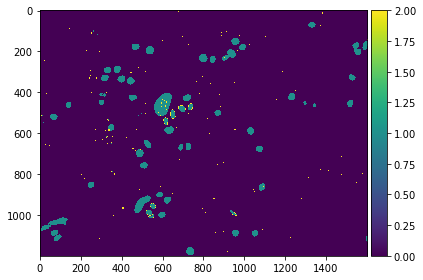

In [64]:
imshow(masks[0]-binary_erosion(masks[0]==2, iterations = 1))

In [2]:
from skimage import measure

In [11]:
area = []
for i in range(287):
    area.append(measure.regionprops(label(masks[0])[0])[i]['area'])

NameError: name 'masks' is not defined

In [7]:
import matplotlib.pyplot as plt

(array([238.,  46.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 6.9520e+02, 1.3894e+03, 2.0836e+03, 2.7778e+03,
        3.4720e+03, 4.1662e+03, 4.8604e+03, 5.5546e+03, 6.2488e+03,
        6.9430e+03]),
 <BarContainer object of 10 artists>)

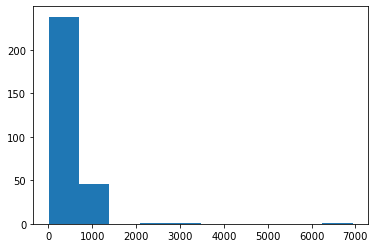

In [97]:
plt.hist(area)

# iRFP masks

Generating statistics about upper and lower bounds for area and ellipsivity of definitive GFP segments (found by iRFP segmentation)

ND0022 Pos12

In [8]:
irfp_masks = DaskOctopusLiteLoader('/home/nathan/data/kraken/ras/ND0022/Pos12/Pos12_images/')['mask_irfp']

In [9]:
from tqdm.auto import tqdm

In [57]:
mask = (label(irfp_masks[282])[0])

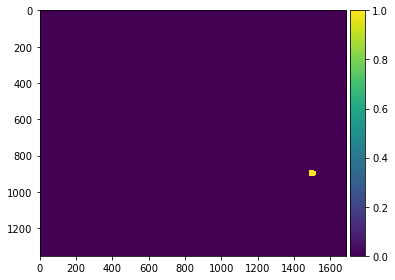

In [58]:
imshow((mask==169).astype(int))

In [10]:
props = [] # list of image region props
area_dist = []
ecc_dist = []
for mask in tqdm(irfp_masks):
    mask_props = measure.regionprops(label(mask)[0])
    #props.append(mask_props)
    for segment in mask_props:
        area_dist.append(segment.area)
        ecc_dist.append(segment.eccentricity)

  0%|          | 0/1098 [00:00<?, ?it/s]

(array([1.7000e+01, 1.5770e+03, 4.2860e+03, 3.1940e+03, 2.0070e+03,
        1.5220e+03, 1.5010e+03, 1.1960e+03, 1.2700e+03, 1.2730e+03,
        1.3480e+03, 1.4360e+03, 1.5840e+03, 1.7810e+03, 1.9950e+03,
        2.3780e+03, 2.9130e+03, 3.5860e+03, 4.5930e+03, 5.5700e+03,
        6.7850e+03, 7.2440e+03, 7.8390e+03, 8.3830e+03, 9.2730e+03,
        9.7340e+03, 1.0392e+04, 1.0899e+04, 1.1307e+04, 1.0992e+04,
        1.1554e+04, 1.2005e+04, 1.2458e+04, 1.1370e+04, 1.0383e+04,
        1.0062e+04, 9.8840e+03, 9.0050e+03, 8.4170e+03, 7.9740e+03,
        7.9760e+03, 7.2380e+03, 6.7050e+03, 6.2910e+03, 6.1850e+03,
        5.6900e+03, 5.6320e+03, 5.3110e+03, 5.2010e+03, 5.0250e+03,
        4.5680e+03, 4.4230e+03, 4.3270e+03, 3.7280e+03, 3.4750e+03,
        3.1420e+03, 2.9960e+03, 2.5590e+03, 2.2110e+03, 1.9400e+03,
        1.8700e+03, 1.7010e+03, 1.5830e+03, 1.5820e+03, 1.4790e+03,
        1.3880e+03, 1.2360e+03, 1.2560e+03, 1.0920e+03, 1.0110e+03,
        9.8500e+02, 8.6400e+02, 8.1800e+02, 6.89

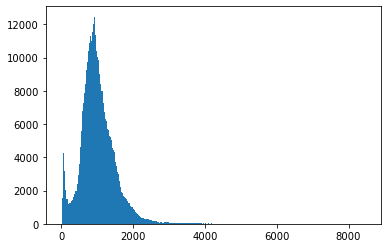

In [11]:
plt.hist(area_dist, bins = 300)

([<matplotlib.axis.XTick at 0x7f9bdb097ee0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

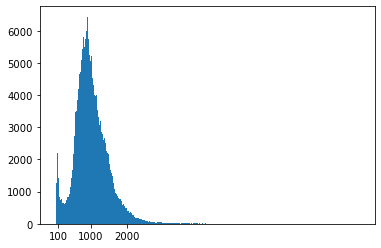

In [36]:
plt.hist(area_dist, bins = 600,)
plt.xticks([100,1000, 2000])

In [12]:
np.std(area_dist)

490.2299756669125

(array([1.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 5.000e+00, 5.000e+00,
        1.000e+01, 9.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 5.000e+00,
        7.000e+00, 7.000e+00, 1.600e+01, 1.300e+01, 1.400e+01, 1.000e+01,
        1.200e+01, 2.100e+01, 1.900e+01, 1.800e+01, 2.200e+01, 2.700e+01,
        3.300e+01, 3.700e+01, 2.600e+01, 3.600e+01, 3.300e+01, 3.700e+01,
        4.300e+01, 4.700e+01, 5.500e+01, 5.900e+01, 6.500e+01, 6.600e+01,
        6.400e+01, 6.400e+01, 7.000e+01, 8.400e+01, 8.400e+01, 9.600e+01,
        9.000e+01, 1.110e+02, 1.240e+02, 1.040e+02, 1.190e+02, 1.300e+02,
        1.730e+02, 1.380e+02, 1.370e+02, 1.420e+02, 1.740e+02, 1.780e+02,
        1.780e+02, 1.930e+02, 1.860e+02, 2.090e+02, 2.120e+02, 2.540e+02,
        2.410e+02, 2.580e+02, 2.720e+02, 2.810e+02, 2.970e+02, 2.810e+02,
        2.790e+02, 3.430e+02, 3.330e+0

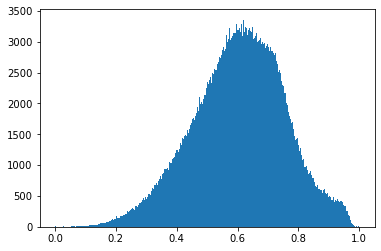

In [13]:
plt.hist(ecc_dist, bins = 300)

In [142]:
np.std(ecc_dist)

0.14550467784319873

In [14]:
import pandas as pd

In [17]:
area_df = pd.DataFrame(area_dist)
ecc_df = pd.DataFrame(ecc_dist)

In [29]:
area_df.quantile(0.98)

0    2190.0
Name: 0.98, dtype: float64

In [27]:
area_df.quantile(0.02)

0    96.0
Name: 0.02, dtype: float64

Check irfp masks

In [37]:
irfp_ = DaskOctopusLiteLoader('/home/nathan/data/kraken/ras/ND0022/Pos12/Pos12_images/')['irfp']
gfp_ = DaskOctopusLiteLoader('/home/nathan/data/kraken/ras/ND0022/Pos12/Pos12_images/')['gfp']

In [38]:
viewer = napari.Viewer()
viewer.add_image(irfp_.astype(np.uint8), name="irfp", 
                 contrast_limits=[0,255],
                 blending = 'additive', colormap = 'red')
viewer.add_image(gfp_.astype(np.uint8), name="gfp", 
                 contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_labels(irfp_masks.astype(np.uint16), name = 'masks',
               blending = 'additive',)


Assistant skips harvesting pyclesperanto as it's not installed.


__init__.py (165): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.


<Labels layer 'masks' at 0x7f9aa52a5e50>

reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
reader.py (147): Background removal works best on cropp